# Analysis of new control run

`/local/projects/so_predict_additional/esm2m_froelicher/pi_control2` --> same variables as original control run

`/local/projects/so_predict_additional/esm2m_froelicher/pi_control` --> new limitation variables

[TOPAZ reference](https://data1.gfdl.noaa.gov/~arl/pubrel/r/mom4p1/src/ocean_shared/generic_tracers/generic_TOPAZ.F90)


In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore",message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt
import cmocean.cm as cm

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs

In [2]:
rootdir = '/home/bbuchovecky/storage/so_predict_additional/esm2m_froelicher/pi_control/'
rootdir2 = '/home/bbuchovecky/storage/so_predict_additional/esm2m_froelicher/pi_control2/'
writedir = '/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/'

## Preprocessing
1. Load grid data for ocean component of model
1. Load regional masks for the Southern Ocean

In [4]:
ocean_grid = xr.open_dataset('/local/projects/so_predict/esm2m_froelicher/GRID/ocean.static.nc')
geolat_t = ocean_grid.geolat_t
geolon_t = ocean_grid.geolon_t

reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')

### SIE
1. Open `CN` dataset
2. Sum over thickness to get `cn_inv`
3. Add metadata

In [14]:
cn = xr.open_mfdataset(rootdir2+'CN*.nc')
attrs = cn['CN'].attrs
cn_inv = cn.sum(dim='ct')
cn_inv = cn_inv.assign(cn_inv=cn_inv['CN']).drop('CN')

cn_inv['cn_inv'].attrs = attrs
cn_inv['cn_inv'].attrs['long_name'] = 'Ice Concentration summed over thickness'
cn_inv = cn_inv.rename({'xt':'xt_ocean', 'yt':'yt_ocean'})
cn_inv = cn_inv.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})
cn_inv = cn_inv.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

3. Create a binary mask `sie_mask` for $SIC > 0.15$

In [6]:
## create mask for SIE where SIC > 15%
sie_mask = xr.where(cn_inv['cn_inv'] > 0.15, 1, 0)

## replace values over land with NaN
sie_mask = xr.where(np.isnan(cn_inv['cn_inv']), np.nan, sie_mask)

## change type to reduce file size
sie_mask = sie_mask.astype(np.float32)

## assign metadata
sie_mask.name = 'sie_mask'
sie_mask.attrs = {'long_name':'Sea Ice Extent (binary threshold @ >15% SIC)',
                  'coordinates':'geolon_t, geolat_t'}

4. Multiply the binary mask `sie_mask` by the grid cell area

In [7]:
sie_gridcell = sie_mask * ocean_grid.area_t

sie_gridcell.name = 'sie'
sie_gridcell.attrs = {'long_name':'Sea Ice Extent', 'units':'m ^2', 'coordinates':'geolon_t, geolat_t', 'description':'area of ice per tracer cell'}

### SIV
1. Load sea ice thickness `HI` dataset
2. Add metadata

In [12]:
hi = xr.open_mfdataset(rootdir2+'HI*.nc')
attrs = hi['HI'].attrs
hi = hi.assign(hi=hi['HI']).drop('HI')

hi['hi'].attrs = attrs
hi['hi'].attrs['long_name'] = 'Ice Thickness'
hi = hi.rename({'xt':'xt_ocean', 'yt':'yt_ocean'})
hi = hi.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})
hi = hi.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

3. Multiply sea ice concentration by grid cell area to get sea ice area (no thresholding)
4. Multiply ice thickness by sea ice area
5. Add metadata

In [36]:
si_total_area = cn_inv * ocean_grid.area_t

siv = si_total_area['cn_inv'] * hi['hi']
siv.attrs = {'long_name':'Sea Ice Volume', 'units':'m ^3', 'coordinates':'geolon_t, geolat_t', 'cell_methods':'time:mean', 'time_avg_info':'average_T1,average_T2,average_DT'}
siv = siv.rename('siv')

### Biomass
1. Open `sfc_ndi`, `sfc_nlg_diatoms`, `sfc_nlg_nondiatoms`, and `sfc_nsm` datasets
2. Create new dataset `sfc_biomass` which is the sum of the four phytoplankton classes

In [6]:
ndi = xr.open_mfdataset(rootdir2+'sfc_ndi*.nc')
diatoms = xr.open_mfdataset(rootdir2+'sfc_nlg_diatoms*.nc')
nondiatoms = xr.open_mfdataset(rootdir2+'sfc_nlg_nondiatoms*.nc')
nsm = xr.open_mfdataset(rootdir2+'sfc_nsm*.nc')

In [7]:
sfc_biomass = ndi.copy(deep=True).rename({'sfc_ndi':'sfc_biomass'})
sfc_biomass = sfc_biomass.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

sfc_biomass['sfc_biomass'] = ndi['sfc_ndi'] + diatoms['sfc_nlg_diatoms'] + nondiatoms['sfc_nlg_nondiatoms'] + nsm['sfc_nsm']

sfc_biomass['sfc_biomass'].attrs = {'long_name':'Total Surface Nitrogen',
                     'units':'mol/kg',
                     'description':'Surface Diazotroph Nitrogen + Surface Large Diatom Nitrogen + Surface Large Non-Diatom Nitrogen + Surface Small Phyotplankton Nitrogen',
                     'cell_methods':'time: mean',
                     'time_avg_info':'average_T1,average_T2,average_DT'}


### Nutrient limitation
1. open `liebig_lim_lg` and `liebig_lim_sm` datasets
2. Reassign coordinates and adjust metadata

In [23]:
liebig_lim_lg = xr.open_mfdataset(rootdir+'liebig_lim_Lg*.nc')
lg_attrs = liebig_lim_lg['liebig_lim_Lg'].attrs
liebig_lim_lg['liebig_lim_Lg'] = liebig_lim_lg['liebig_lim_Lg'].sum(dim='st_ocean_sub02')
liebig_lim_lg = liebig_lim_lg.assign(liebig_lim_lg=liebig_lim_lg['liebig_lim_Lg']).drop('liebig_lim_Lg')
liebig_lim_lg = liebig_lim_lg.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})
liebig_lim_lg['liebig_lim_lg'].attrs = lg_attrs
liebig_lim_lg['liebig_lim_lg'].attrs['long_name'] = lg_attrs['long_name']+' upper 100m'

liebig_lim_sm = xr.open_mfdataset(rootdir+'liebig_lim_Sm*.nc')
sm_attrs = liebig_lim_sm['liebig_lim_Sm'].attrs
liebig_lim_sm['liebig_lim_Sm'] = liebig_lim_sm['liebig_lim_Sm'].sum(dim='st_ocean_sub02')
liebig_lim_sm = liebig_lim_sm.assign(liebig_lim_sm=liebig_lim_sm['liebig_lim_Sm']).drop('liebig_lim_Sm')
liebig_lim_sm = liebig_lim_sm.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})
liebig_lim_sm['liebig_lim_sm'].attrs = sm_attrs
liebig_lim_sm['liebig_lim_sm'].attrs['long_name'] = sm_attrs['long_name']+' upper 100m'

! `liebig_lim_Sm` and `liebig_lim_Lg` are the same !

In [6]:
(liebig_lim_sm['liebig_lim_sm'] == liebig_lim_lg['liebig_lim_lg']).min().values

array(True)

### Light limitation

In [42]:
irrlim_lg = xr.open_mfdataset(rootdir+'irrlim_Lg*.nc')
lg_attrs = irrlim_lg['irrlim_Lg'].attrs
irrlim_lg['irrlim_Lg'] = irrlim_lg['irrlim_Lg'].sum(dim='st_ocean_sub02')
irrlim_lg = irrlim_lg.assign(irrlim_lg=irrlim_lg['irrlim_Lg']).drop('irrlim_Lg')
irrlim_lg = irrlim_lg.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})
irrlim_lg['irrlim_lg'].attrs = lg_attrs
irrlim_lg['irrlim_lg'].attrs['long_name'] = lg_attrs['long_name']+' upper 100m'

irrlim_sm = xr.open_mfdataset(rootdir+'irrlim_Sm*.nc')
sm_attrs = irrlim_sm['irrlim_Sm'].attrs
irrlim_sm['irrlim_Sm'] = irrlim_sm['irrlim_Sm'].sum(dim='st_ocean_sub02')
irrlim_sm = irrlim_sm.assign(irrlim_sm=irrlim_sm['irrlim_Sm']).drop('irrlim_Sm')
irrlim_sm = irrlim_sm.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})
irrlim_sm['irrlim_sm'].attrs = sm_attrs
irrlim_sm['irrlim_sm'].attrs['long_name'] = sm_attrs['long_name']+' upper 100m'

## Functions for analysis

In [14]:
def comp_gc_metrics(
    ds, variable, resize=False, save=False):
    
    writedir = '/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/'
    subdir = variable.upper()+'/'
    reg = 'global'
    
    da = ds[variable.lower()]
    
    if resize:
        da = pcs.SouthernOcean_resize(da, time=True)
        reg = 'so'
    
    ## global climatology
    clim = da.groupby('time.month').mean(dim='time')
    clim.name = variable.lower()+'_clim'
    clim.attrs = da.attrs
    clim.attrs['description'] = 'monthly climatology'
    
    clim_name = variable.lower()+'_gc_'+reg+'_clim.nc'
    clim = clim.to_dataset()
    clim.attrs['name'] = clim_name
    
    ## global monthly anomaly
    anom = da.groupby('time.month') - clim[variable.lower()+'_clim']
    anom.name = variable.lower()+'_anom'
    anom.attrs = da.attrs
    anom.attrs['description'] = 'monthly anomaly'
    
    anom_name = variable.lower()+'_gc_'+reg+'_monthly_anom.nc'
    anom = anom.to_dataset()
    anom.attrs['name'] = anom_name
    
    ## global monthly variance
    var = anom[variable.lower()+'_anom'].groupby('time.month').var(dim='time')
    var.name = variable.lower()+'_var'
    var.attrs = da.attrs
    var.attrs['units'] = '( '+da.attrs['units']+' )^2'
    var.attrs['description'] = 'variance of monthly anomaly'
    
    var_name = variable.lower()+'_gc_'+reg+'_monthly_var.nc'
    var = var.to_dataset()
    var.attrs['name'] = var_name
    
    if save:
        clim.to_netcdf(writedir+subdir+clim_name)
        anom.to_netcdf(writedir+subdir+anom_name)
        var.to_netcdf(writedir+subdir+var_name)
        
        print(writedir+subdir+clim_name)
        print(writedir+subdir+anom_name)
        print(writedir+subdir+var_name)
        
    if not save:
        print(writedir+subdir+clim_name)
        print(writedir+subdir+anom_name)
        print(writedir+subdir+var_name)
        return clim,anom,var

In [15]:
def comp_annual_mean(
    ds, var, reg, save=False):
    
    writedir = '/home/bbuchovecky/storage/so_predict_additional_derived/'
    reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
    
    ## get ocean model grid information
    ocean_grid = xr.open_dataset('/local/projects/so_predict/esm2m_froelicher/GRID/ocean.static.nc')
    
    ## get grid-cell area for the ocean only
    total_area = xr.where(np.isnan(ds[var][0]), np.nan, ocean_grid['area_t'])
    
    ## global mean
    if reg == 'global':
        area_sum = total_area.sum(dim={'xt_ocean', 'yt_ocean'})
        
        if var.lower() == 'sie' or var == 'siv':
            annual_mean = ds[var].groupby('time.year').mean(dim='time').sum(dim={'xt_ocean', 'yt_ocean'})
        else:
            annual_mean = (ds[var] * ocean_grid['area_t']).groupby('time.year').mean(dim='time').sum(dim={'xt_ocean', 'yt_ocean'}) / area_sum
            annual_mean = annual_mean.drop('time')
        
        annual_mean.name = 'Global'
        annual_mean.attrs = ds[var].attrs
        annual_mean.attrs['description'] = 'annual mean'
        annual_mean = annual_mean.to_dataset()        
        
        filename = var.lower()+'_ts_'+reg+'_annual_mean.nc'
        annual_mean.attrs['name'] = filename
        
        if save:
            annual_mean.to_netcdf(writedir+'CTRL/'+var.upper()+'/'+filename)
            print(writedir+'CTRL/'+var.upper()+'/'+filename)
        if not save:
            print(writedir+'CTRL/'+var.upper()+'/'+filename)
            return annual_mean
    
    ## regional mean
    if reg == 'so':
        regions = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
        reg_mean = []
        
        for r in regions:
            area = total_area.where(reg_masks[r] == 1)
            area_sum = area.sum(dim={'xt_ocean', 'yt_ocean'})
            reg_var = ds[var].where(reg_masks[r] == 1)
            
            if var.lower() == 'sie' or var == 'siv':
                annual_mean = reg_var.groupby('time.year').mean(dim='time').sum(dim={'xt_ocean', 'yt_ocean'})
            else:
                annual_mean = (reg_var * ocean_grid['area_t']).groupby('time.year').mean(dim='time').sum(dim={'xt_ocean', 'yt_ocean'}) / area_sum
                annual_mean = annual_mean.drop('time')
            
            annual_mean.name = r
            annual_mean.attrs = ds[var].attrs
            annual_mean.attrs['description'] = 'annual mean'
            
            reg_mean.append(annual_mean.copy(deep=True))
            
        annual_mean = xr.merge(reg_mean)
        
        filename = var.lower()+'_ts_'+reg+'_annual_mean.nc'
        annual_mean.attrs = {}
        annual_mean.attrs['name'] = filename
        
        if save:
            annual_mean.to_netcdf(writedir+'CTRL/'+var.upper()+'/'+filename)
            print(writedir+'CTRL/'+var.upper()+'/'+filename)
        if not save:
            print(writedir+'CTRL/'+var.upper()+'/'+filename)
            return annual_mean

In [16]:
def comp_monthly_mean(
    ds, var, reg, save=False):
    
    writedir = '/home/bbuchovecky/storage/so_predict_additional_derived/'
    reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
    
    ## get ocean model grid information
    ocean_grid = xr.open_dataset('/local/projects/so_predict/esm2m_froelicher/GRID/ocean.static.nc')
    
    ## get grid-cell area for the ocean only
    total_area = xr.where(np.isnan(ds[var][0]), np.nan, ocean_grid['area_t'])
    
    ## global mean
    if reg == 'global':
        area_sum = total_area.sum(dim={'xt_ocean', 'yt_ocean'})
        
        if var.lower() == 'sie' or var.lower() == 'siv':
            monthly_mean = ds[var].sum(dim={'xt_ocean', 'yt_ocean'})
        else:
            monthly_mean = (ds[var] * ocean_grid['area_t']).sum(dim={'xt_ocean', 'yt_ocean'}) / area_sum
        
        monthly_mean.name = 'Global'
        monthly_mean.attrs = ds[var].attrs
        monthly_mean.attrs['description'] = 'monthly mean'
        monthly_mean = monthly_mean.to_dataset()
        
        filename = var.lower()+'_ts_'+reg+'_monthly_mean.nc'
        monthly_mean.attrs['name'] = filename
        
        if save:
            monthly_mean.to_netcdf(writedir+'CTRL/'+var.upper()+'/'+filename)
            print(writedir+'CTRL/'+var.upper()+'/'+filename)
        if not save:
            print(writedir+'CTRL/'+var.upper()+'/'+filename)
            return monthly_mean
    
    ## regional mean
    if reg == 'so':
        regions = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
        reg_mean = []
        
        for r in regions:
            area = total_area.where(reg_masks[r] == 1)
            area_sum = area.sum(dim={'xt_ocean', 'yt_ocean'})
            reg_var = ds[var].where(reg_masks[r] == 1)
            
            if var.lower() == 'sie' or var.lower() == 'siv':
                monthly_mean = reg_var.sum(dim={'xt_ocean', 'yt_ocean'})
            else:
                monthly_mean = (reg_var * ocean_grid['area_t']).sum(dim={'xt_ocean', 'yt_ocean'}) / area_sum
            
            monthly_mean.name = r
            monthly_mean.attrs = ds[var].attrs
            monthly_mean.attrs['description'] = 'monthly mean'
            
            reg_mean.append(monthly_mean.copy(deep=True))
            
        monthly_mean = xr.merge(reg_mean)
        
        filename = var.lower()+'_ts_'+reg+'_monthly_mean.nc'
        monthly_mean.attrs = {}
        monthly_mean.attrs['name'] = filename
        
        if save:
            monthly_mean.to_netcdf(writedir+'CTRL/'+var.upper()+'/'+filename)
            print(writedir+'CTRL/'+var.upper()+'/'+filename)
        if not save:
            print(writedir+'CTRL/'+var.upper()+'/'+filename)
            return monthly_mean

In [17]:
def comp_monthly_anom(
    var, reg, mean=None, save=False):
    
    writedir = '/home/bbuchovecky/storage/so_predict_additional_derived/'
    
    if os.path.isfile(writedir+'CTRL/'+var.upper()+'/'+var.lower()+'_ts_'+reg+'_monthly_mean.nc') and mean == None:
        mean = xr.open_dataset(writedir+'CTRL/'+var.upper()+'/'+var.lower()+'_ts_'+reg+'_monthly_mean.nc')
        print('Source: '+var.lower()+'_ts_'+reg+'_monthly_mean.nc')

    ds_anom = mean.copy(deep=True)
    ds_anom['month'] = np.arange(1,6001)
    
    for r in ds_anom.data_vars:
        ds_anom[r] = (('month'), ds_anom[r])
        
    ds_anom = ds_anom.drop('time')
    
    for r in mean.data_vars:
        np_clim = mean[r].groupby('time.month').mean(dim='time').values
        np_mean = mean[r].values

        reg_anom = np.zeros(6000)
        for m in range(0,6000):
            reg_anom[m] = np_mean[m] - np_clim[m%12]

        ds_anom[r] = (('month'), reg_anom)
        ds_anom[r].attrs = mean[r].attrs
        ds_anom[r].attrs['description'] = 'monthly anomaly'
    
    filename = var.lower()+'_ts_'+reg+'_monthly_anom.nc'
    ds_anom.attrs['name'] = filename
    
    if save:
        ds_anom.to_netcdf(writedir+'CTRL/'+var.upper()+'/'+filename)
        print(writedir+'CTRL/'+var.upper()+'/'+filename)
    if not save:
        print(writedir+'CTRL/'+var.upper()+'/'+filename)
        return ds_anom

In [18]:
def comp_monthly_var(
    var, reg, anom=None, save=False):
    
    writedir = '/home/bbuchovecky/storage/so_predict_additional_derived/'
    
    if os.path.isfile(writedir+'CTRL/'+var.upper()+'/'+var.lower()+'_ts_'+reg+'_monthly_anom.nc') and anom == None:
        anom = xr.open_dataset(writedir+'CTRL/'+var.upper()+'/'+var.lower()+'_ts_'+reg+'_monthly_anom.nc')
        print('Source: '+var.lower()+'_ts_'+reg+'_monthly_anom.nc')
    
    ds_var = anom.copy(deep=True)
    
    if reg == 'global':
        ds_var = ds_var.drop({'month','Global'})
        ds_var['month'] = np.arange(1,13)
        
        np_anom = np.zeros((12,300))
        
        ## group anomaly data by month
        for r in anom.data_vars:
            for m in range(0,3600):           
                np_anom[m%12][int(m/12)] = anom[r].isel(month=m)
        
        ## compute variance
        np_var = np.var(np_anom, axis=1)
        if np.shape(np_var) != (12,):
            raise Exception('variance array is the wrong shape')
            
        ## migrate data from numpy array to dataset
        ds_var['Global'] = (('month'), np_var)
        ds_var['Global'].attrs['name'] = 'variance of monthly anomaly'
    
    if reg == 'so':
        ds_var = ds_var.drop({'month','SouthernOcean','Weddell','Indian','WestPacific','Ross','AmundBell'})
        ds_var['month'] = np.arange(1,13)
        
        np_anom = np.zeros((len(anom.data_vars),12,300))
        
        ## group anomaly data by month
        for (r,i) in zip(anom.data_vars,range(6)):
            for m in range(0,3600):           
                np_anom[i][m%12][int(m/12)] = anom[r].isel(month=m)
        
        ## compute variance
        np_var = np.var(np_anom, axis=2)
        if np.shape(np_var) != (6,12):
            raise Exception('variance array is the wrong shape')
        
        ## migrate data from numpy array to dataset
        for (r,i) in zip(anom.data_vars, range(6)):
            ds_var[r] = (('month'), np_var[i])
            ds_var[r].attrs['name'] = 'variance of monthly anomaly'
    
    filename = var.lower()+'_ts_'+reg+'_monthly_var.nc'
    ds_var.attrs['name'] = filename
    
    if save:
        ds_var.to_netcdf(writedir+'CTRL/'+var.upper()+'/'+filename)
        print(writedir+'CTRL/'+var.upper()+'/'+filename)
    if not save:
        print(writedir+'CTRL/'+var.upper()+'/'+filename)
        return ds_var

## Compute grid cell metrics and timeseries
Climatology, monthly mean, monthly anomaly, and monthly variance for the Southern Ocean regions and globally

In [ ]:
# variables = ['mld', 'pco2surf', 'sfc_fed', 'sfc_chl', 'sfc_irr_mem', 'sss', 'sst']

# for var in variables:
#     print('\n#### '+var.upper()+' ####')
#     ds = xr.open_mfdataset(rootdir2+var+'*.nc')
#     ds = ds.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})
#     ds = ds.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})
    
#     print('Gridcell metrics - global')
#     comp_gc_metrics(ds, var, resize=False, save=True)
#     print('Gridcell metrics - SO')
#     comp_gc_metrics(ds, var, resize=True, save=True)
#     print('Annual mean - global')
#     comp_annual_mean(ds, var, 'global', save=True)
#     print('Annual mean - SO')
#     comp_annual_mean(ds, var, 'so', save=True)
#     print('Monthly mean - global')
#     comp_monthly_mean(ds, var, 'global', save=True)
#     print('Monthly mean - SO')
#     comp_monthly_mean(ds, var, 'so', save=True)
#     print('Monthly anomaly - global')
#     comp_monthly_anom(var, 'global', save=True)
#     print('Monthly anomaly - SO')
#     comp_monthly_anom(var, 'so', save=True)
#     print('Monthly variance - global')
#     comp_monthly_var(var, 'global', save=True)
#     print('Monthly variance - SO')
#     comp_monthly_var(var, 'so', save=True)

In [ ]:
# ds = sfc_biomass
# var = 'sfc_biomass'

# print('\n#### '+var.upper()+' ####')
# print('Gridcell metrics - global')
# comp_gc_metrics(ds, var, resize=False, save=True)
# print('Gridcell metrics - SO')
# comp_gc_metrics(ds, var, resize=True, save=True)
# print('Annual mean - global')
# comp_annual_mean(ds, var, 'global', save=True)
# print('Annual mean - SO')
# comp_annual_mean(ds, var, 'so', save=True)
# print('Monthly mean - global')
# comp_monthly_mean(ds, var, 'global', save=True)
# print('Monthly mean - SO')
# comp_monthly_mean(ds, var, 'so', save=True)
# print('Monthly anomaly - global')
# comp_monthly_anom(var, 'global', save=True)
# print('Monthly anomaly - SO')
# comp_monthly_anom(var, 'so', save=True)
# print('Monthly variance - global')
# comp_monthly_var(var, 'global', save=True)
# print('Monthly variance - SO')
# comp_monthly_var(var, 'so', save=True)

In [ ]:
# ds = cn_inv
# var = 'cn_inv'

# print('\n#### '+var.upper()+' ####')
# print('Gridcell metrics - global')
# comp_gc_metrics(ds, var, resize=False, save=True)
# print('Gridcell metrics - SO')
# comp_gc_metrics(ds, var, resize=True, save=True)
# print('Annual mean - global')
# comp_annual_mean(ds, var, 'global', save=True)
# print('Annual mean - SO')
# comp_annual_mean(ds, var, 'so', save=True)
# print('Monthly mean - global')
# comp_monthly_mean(ds, var, 'global', save=True)
# print('Monthly mean - SO')
# comp_monthly_mean(ds, var, 'so', save=True)
# print('Monthly anomaly - global')
# comp_monthly_anom(var, 'global', save=True)
# print('Monthly anomaly - SO')
# comp_monthly_anom(var, 'so', save=True)
# print('Monthly variance - global')
# comp_monthly_var(var, 'global', save=True)
# print('Monthly variance - SO')
# comp_monthly_var(var, 'so', save=True)

In [ ]:
# ds = sie_gridcell.to_dataset()
# var = 'sie'

# print('\n#### '+var.upper()+' ####')
# print('Gridcell metrics - global')
# comp_gc_metrics(ds, var, resize=False, save=True)
# print('Gridcell metrics - SO')
# comp_gc_metrics(ds, var, resize=True, save=True)
# print('Annual mean - global')
# comp_annual_mean(ds, var, 'global', save=True)
# print('Annual mean - SO')
# comp_annual_mean(ds, var, 'so', save=True)
# print('Monthly mean - global')
# comp_monthly_mean(ds, var, 'global', save=True)
# print('Monthly mean - SO')
# comp_monthly_mean(ds, var, 'so', save=True)
# print('Monthly anomaly - global')
# comp_monthly_anom(var, 'global', save=True)
# print('Monthly anomaly - SO')
# comp_monthly_anom(var, 'so', save=True)
# print('Monthly variance - global')
# comp_monthly_var(var, 'global', save=True)
# print('Monthly variance - SO')
# comp_monthly_var(var, 'so', save=True)

In [ ]:
# ds = siv.to_dataset()
# var = 'siv'

# print('\n#### '+var.upper()+' ####')
# print('Gridcell metrics - global')
# comp_gc_metrics(ds, var, resize=False, save=True)
# print('Gridcell metrics - SO')
# comp_gc_metrics(ds, var, resize=True, save=True)
# print('Annual mean - global')
# comp_annual_mean(ds, var, 'global', save=True)
# print('Annual mean - SO')
# comp_annual_mean(ds, var, 'so', save=True)
# print('Monthly mean - global')
# comp_monthly_mean(ds, var, 'global', save=True)
# print('Monthly mean - SO')
# comp_monthly_mean(ds, var, 'so', save=True)
# print('Monthly anomaly - global')
# comp_monthly_anom(var, 'global', save=True)
# print('Monthly anomaly - SO')
# comp_monthly_anom(var, 'so', save=True)
# print('Monthly variance - global')
# comp_monthly_var(var, 'global', save=True)
# print('Monthly variance - SO')
# comp_monthly_var(var, 'so', save=True)

In [36]:
# var = 'jprod_ntot_100'
# ds = xr.open_mfdataset(rootdir2+var+'*.nc')
# ds = ds.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})
# ds = ds.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

# print('\n#### '+var.upper()+' ####')
# print('Gridcell metrics - global')
# comp_gc_metrics(ds, var, resize=False, save=True)
# print('Gridcell metrics - SO')
# comp_gc_metrics(ds, var, resize=True, save=True)
# print('Annual mean - global')
# comp_annual_mean(ds, var, 'global', save=True)
# print('Annual mean - SO')
# comp_annual_mean(ds, var, 'so', save=True)
# print('Monthly mean - global')
# comp_monthly_mean(ds, var, 'global', save=True)
# print('Monthly mean - SO')
# comp_monthly_mean(ds, var, 'so', save=True)
# print('Monthly anomaly - global')
# comp_monthly_anom(var, 'global', save=True)
# print('Monthly anomaly - SO')
# comp_monthly_anom(var, 'so', save=True)
# print('Monthly variance - global')
# comp_monthly_var(var, 'global', save=True)
# print('Monthly variance - SO')
# comp_monthly_var(var, 'so', save=True)


#### JPROD_NTOT_100 ####
Gridcell metrics - global
/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/JPROD_NTOT_100/jprod_ntot_100_gc_global_clim.nc
/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/JPROD_NTOT_100/jprod_ntot_100_gc_global_monthly_anom.nc
/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/JPROD_NTOT_100/jprod_ntot_100_gc_global_monthly_var.nc
Gridcell metrics - SO
/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/JPROD_NTOT_100/jprod_ntot_100_gc_so_clim.nc
/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/JPROD_NTOT_100/jprod_ntot_100_gc_so_monthly_anom.nc
/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/JPROD_NTOT_100/jprod_ntot_100_gc_so_monthly_var.nc
Annual mean - global
/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/JPROD_NTOT_100/jprod_ntot_100_ts_global_annual_mean.nc
Annual mean - SO
/home/bbuchovecky/storage/so_predict_additional_derived/CTRL/JPROD_NTOT_100/jprod_ntot_100_ts_so_ann

In [50]:
var = 'irrlim_lg'
ds = irrlim_lg

print('\n#### '+var.upper()+' ####')
print('Gridcell metrics - global')
comp_gc_metrics(ds, var, resize=False, save=True)
print('Gridcell metrics - SO')
comp_gc_metrics(ds, var, resize=True, save=True)
print('Annual mean - global')
comp_annual_mean(ds, var, 'global', save=True)
print('Annual mean - SO')
comp_annual_mean(ds, var, 'so', save=True)
print('Monthly mean - global')
comp_monthly_mean(ds, var, 'global', save=True)
print('Monthly mean - SO')
comp_monthly_mean(ds, var, 'so', save=True)
print('Monthly anomaly - global')
comp_monthly_anom(var, 'global', save=True)
print('Monthly anomaly - SO')
comp_monthly_anom(var, 'so', save=True)
print('Monthly variance - global')
comp_monthly_var(var, 'global', save=True)
print('Monthly variance - SO')
comp_monthly_var(var, 'so', save=True)


#### IRRLIM_LG ####
Gridcell metrics - global


KeyboardInterrupt: 

In [ ]:
var = 'irrlim_sm'
ds = irrlim_sm

print('\n#### '+var.upper()+' ####')
print('Gridcell metrics - global')
comp_gc_metrics(ds, var, resize=False, save=True)
print('Gridcell metrics - SO')
comp_gc_metrics(ds, var, resize=True, save=True)
print('Annual mean - global')
comp_annual_mean(ds, var, 'global', save=True)
print('Annual mean - SO')
comp_annual_mean(ds, var, 'so', save=True)
print('Monthly mean - global')
comp_monthly_mean(ds, var, 'global', save=True)
print('Monthly mean - SO')
comp_monthly_mean(ds, var, 'so', save=True)
print('Monthly anomaly - global')
comp_monthly_anom(var, 'global', save=True)
print('Monthly anomaly - SO')
comp_monthly_anom(var, 'so', save=True)
print('Monthly variance - global')
comp_monthly_var(var, 'global', save=True)
print('Monthly variance - SO')
comp_monthly_var(var, 'so', save=True)

## Visualization
1. Plot climatologies

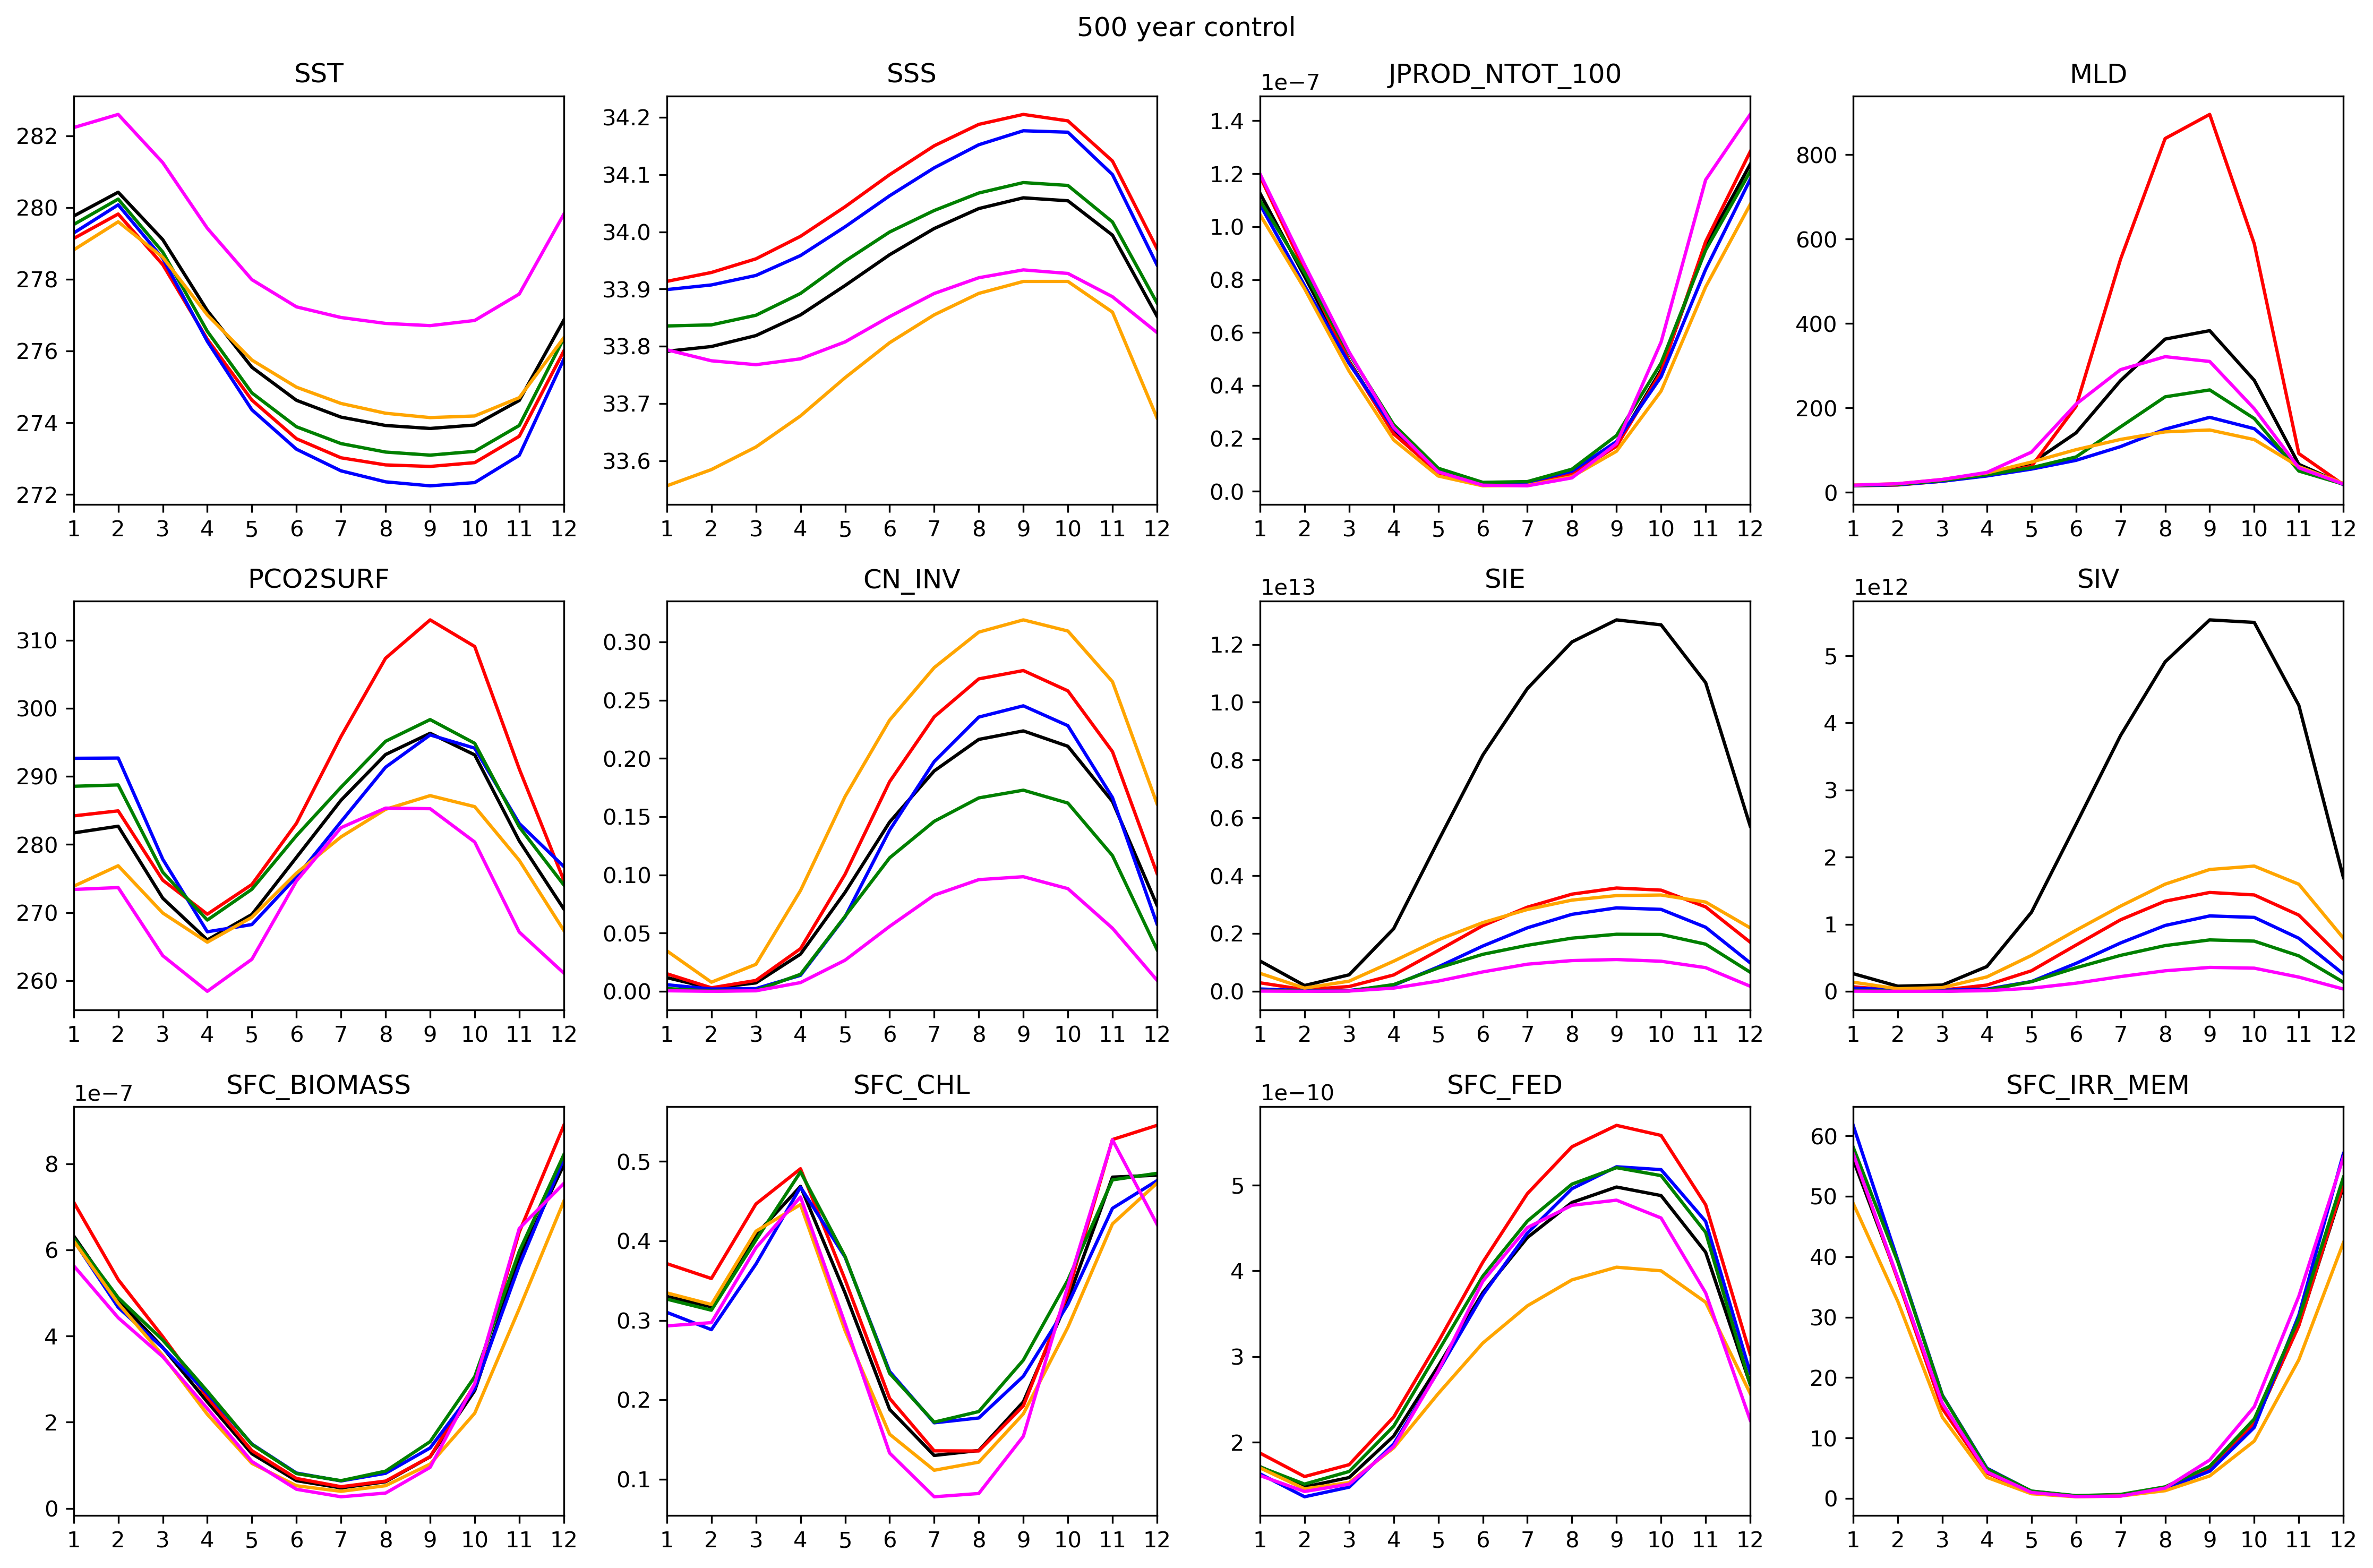

In [48]:
# variables = ['sst', 'sss', 'jprod_ntot_100', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr_mem', 'irrlim_sm', 'irrlim_lg']
variables = ['sst', 'sss', 'jprod_ntot_100', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr_mem']
regions = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']

fig,axs = plt.subplots(3,4,figsize=(15,10))
cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']

for (iv,var) in enumerate(variables):
    da = xr.open_dataset(writedir+var.upper()+'/'+var.lower()+'_ts_so_monthly_mean.nc')
    for (ir,reg) in enumerate(regions):     
        clim = da[reg].groupby('time.month').mean(dim='time')
        axs[iv//4, iv%4].plot(np.arange(1,13), clim.values, color=cmap[ir])
        axs[iv//4, iv%4].set_xticks(np.arange(1,13))
        axs[iv//4, iv%4].set_xticklabels(np.arange(1,13))
        axs[iv//4, iv%4].set_xlim(1,12)
        axs[iv//4, iv%4].set_title(var.upper())

fig.suptitle('500 year control')
fig.tight_layout()
plt.gcf().set_dpi(300)

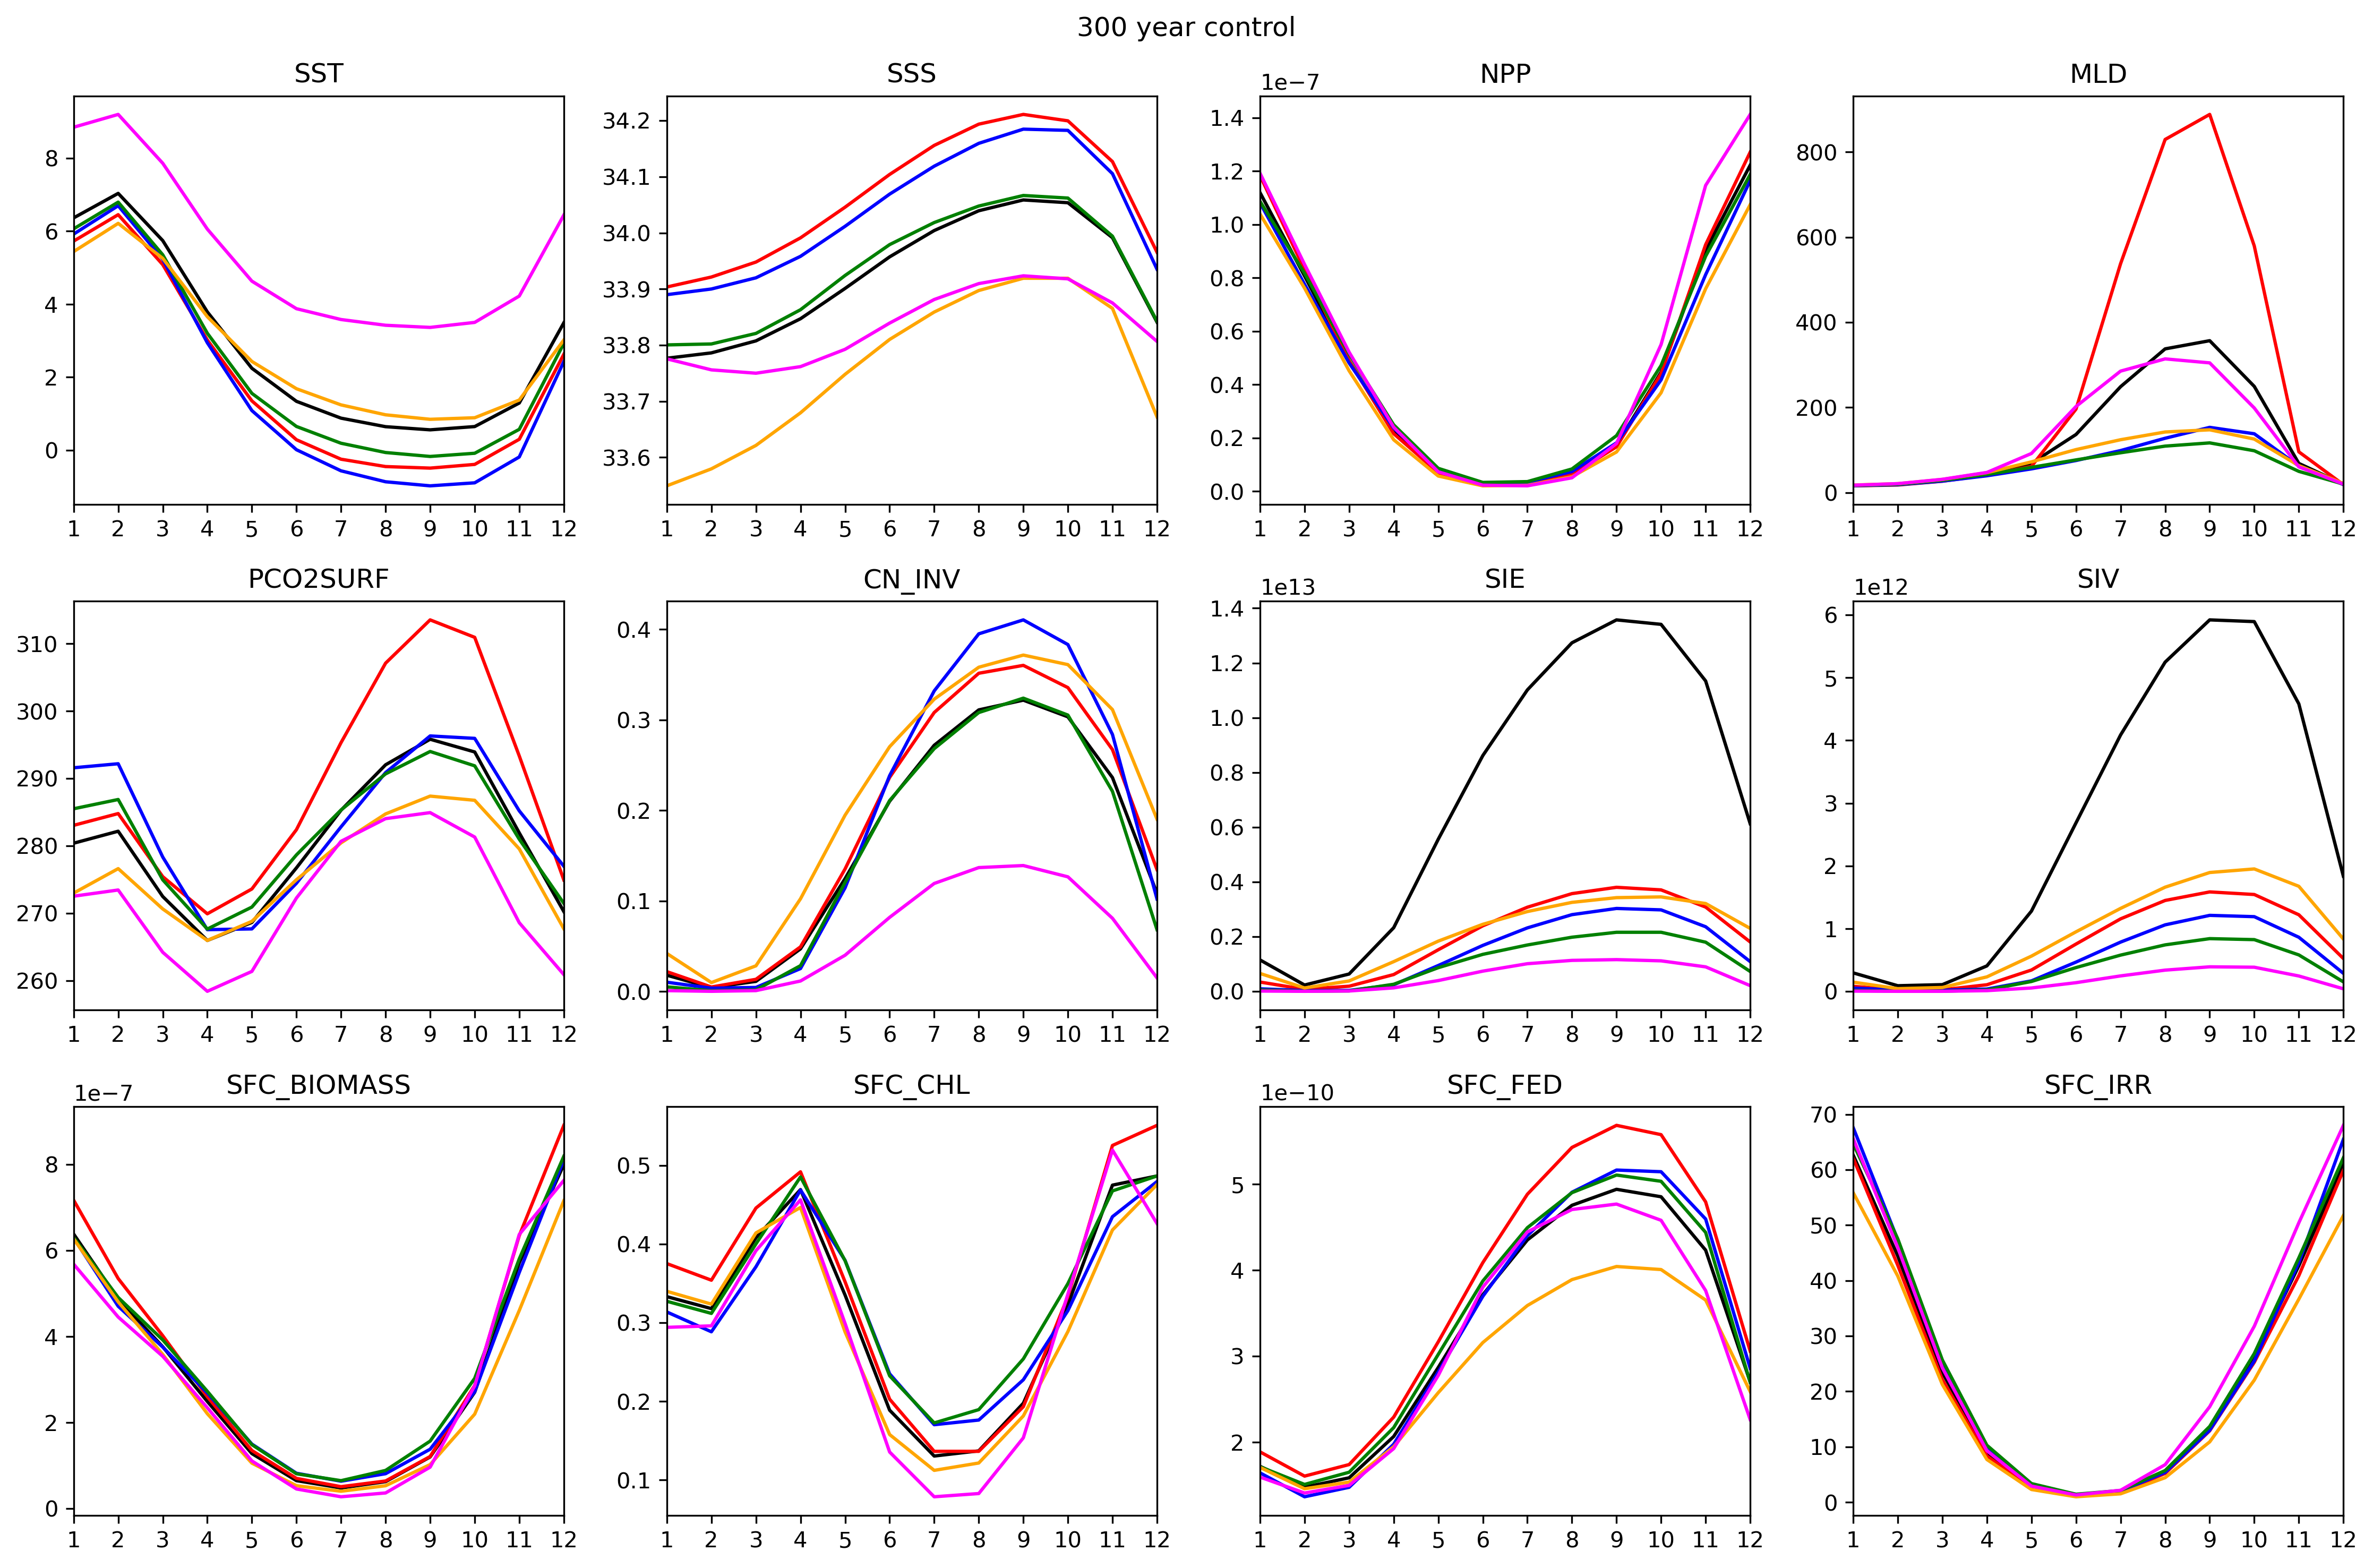

In [49]:
# variables = ['sst', 'sss', 'jprod_ntot_100', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr_mem', 'irrlim_sm', 'irrlim_lg']
variables = ['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr']
regions = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']

fig,axs = plt.subplots(3,4,figsize=(15,10))
cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']

for (iv,var) in enumerate(variables):
    da = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/'+var.upper()+'/'+var.lower()+'_ts_so_monthly_mean.nc')
    for (ir,reg) in enumerate(regions):     
        clim = da[reg].groupby('time.month').mean(dim='time')
        axs[iv//4, iv%4].plot(np.arange(1,13), clim.values, color=cmap[ir])
        axs[iv//4, iv%4].set_xticks(np.arange(1,13))
        axs[iv//4, iv%4].set_xticklabels(np.arange(1,13))
        axs[iv//4, iv%4].set_xlim(1,12)
        axs[iv//4, iv%4].set_title(var.upper())

fig.suptitle('300 year control')
fig.tight_layout()
plt.gcf().set_dpi(300)

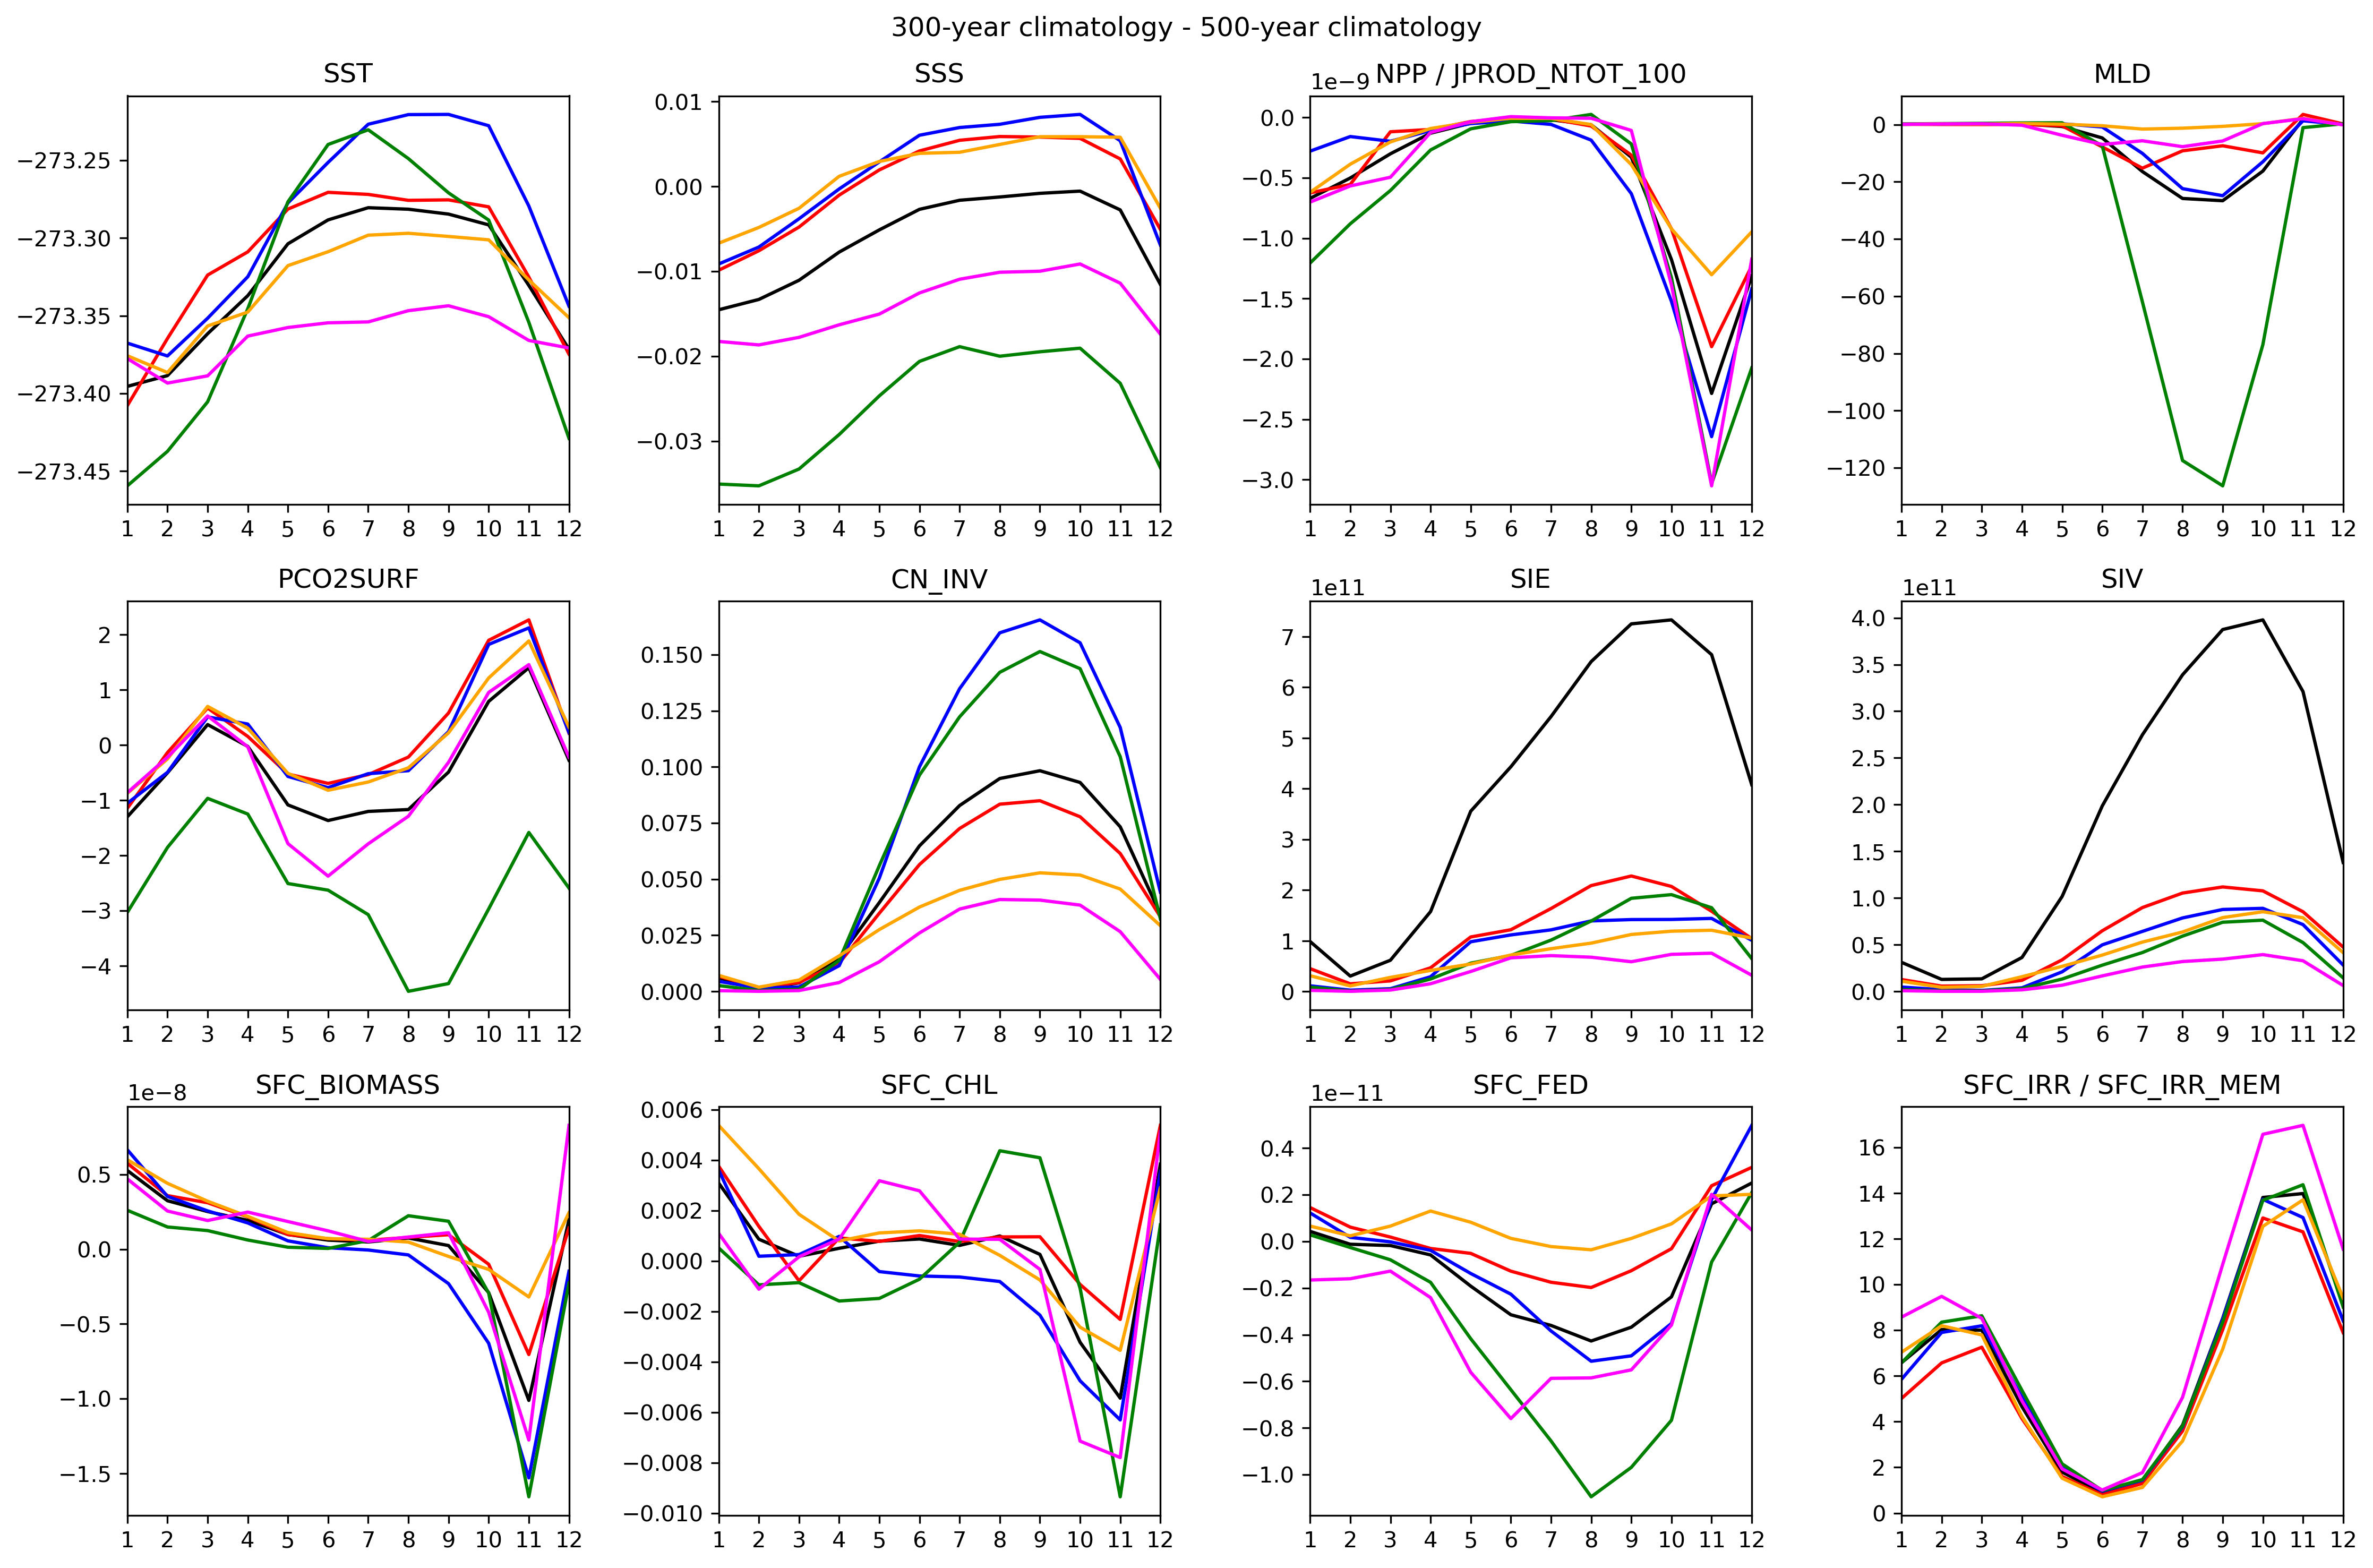

In [58]:
variables = [['sst','sst'], ['sss','sss'], ['npp','jprod_ntot_100'], ['mld','mld'], ['pco2surf','pco2surf'], ['cn_inv','cn_inv'], ['sie','sie'], ['siv','siv'], ['sfc_biomass','sfc_biomass'], ['sfc_chl','sfc_chl'], ['sfc_fed','sfc_fed'], ['sfc_irr','sfc_irr_mem']]
regions = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']

fig,axs = plt.subplots(3,4,figsize=(15,10))
cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']

for (iv,var) in enumerate(variables):
    da300 = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/'+var[0].upper()+'/'+var[0].lower()+'_ts_so_monthly_mean.nc')
    da500 = xr.open_dataset(writedir+var[1].upper()+'/'+var[1].lower()+'_ts_so_monthly_mean.nc')
    
    for (ir,reg) in enumerate(regions):
        climdiff = da300[reg].groupby('time.month').mean(dim='time') - da500[reg].groupby('time.month').mean(dim='time')
        axs[iv//4, iv%4].plot(np.arange(1,13), climdiff.values, color=cmap[ir])
        axs[iv//4, iv%4].set_xticks(np.arange(1,13))
        axs[iv//4, iv%4].set_xticklabels(np.arange(1,13))
        axs[iv//4, iv%4].set_xlim(1,12)
        if var[0] == var[1]:
            axs[iv//4, iv%4].set_title(var[0].upper())
        else:
            axs[iv//4, iv%4].set_title(var[0].upper()+' / '+var[1].upper())
        
fig.suptitle('300-year climatology - 500-year climatology')
fig.tight_layout()
plt.gcf().set_dpi(300)

2. Plot variance

3. Plot `mld` monthly anomaly timeseries to check for deep convection